In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# 加载数据

In [2]:
data = pd.read_csv('../../data/criteo_sampled_data.csv')
data.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,0.0,...,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


In [3]:
data.shape

(600000, 40)

In [4]:
cols = data.columns.values

# 数据预处理

## 定义特征组

In [5]:
dense_feats = [f for f in cols if f[0] == "I"]
sparse_feats = [f for f in cols if f[0] == "C"]

## 处理dense特征

In [6]:
def process_dense_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna(0.0)
    for f in feats:
        d[f] = d[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    
    return d

In [7]:
data_dense = process_dense_feats(data, dense_feats)

## 处理sparse特征

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
def process_sparse_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna("-1")
    for f in feats:
        label_encoder = LabelEncoder()
        d[f] = label_encoder.fit_transform(d[f])
        
    return d

In [10]:
data_sparse = process_sparse_feats(data, sparse_feats)

In [11]:
total_data = pd.concat([data_dense, data_sparse], axis=1)

In [12]:
total_data['label'] = data['label']

# 模型构建与训练

## 一阶特征

### dense特征

In [13]:
import tensorflow as tf

In [14]:
dense_inputs = []
for f in dense_feats:
    _input = Input([1], name=f)
    dense_inputs.append(_input)

In [15]:
dense_inputs

[<tf.Tensor 'I1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I2:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I4:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I5:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I6:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I7:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I8:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I9:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I10:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I11:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I12:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I13:0' shape=(None, 1) dtype=float32>]

In [16]:
concat_dense_inputs = Concatenate(axis=1)(dense_inputs)  # ?, 13
fst_order_dense_layer = Dense(1)(concat_dense_inputs)  # ?, 1

### sparse特征

In [17]:
sparse_inputs = []
for f in sparse_feats:
    _input = Input([1], name=f)
    sparse_inputs.append(_input)

In [18]:
sparse_1d_embed = []
for i, _input in enumerate(sparse_inputs):
    f = sparse_feats[i]
    voc_size = data[f].nunique()
    _embed = Flatten()(Embedding(voc_size+1, 1, embeddings_regularizer=tf.keras.regularizers.l2(0.5))(_input))
    sparse_1d_embed.append(_embed)

In [19]:
sparse_1d_embed

[<tf.Tensor 'flatten/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'flatten_1/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'flatten_2/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'flatten_3/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'flatten_4/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'flatten_5/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'flatten_6/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'flatten_7/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'flatten_8/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'flatten_9/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'flatten_10/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'flatten_11/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'flatten_12/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'flatten_13/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'flatten_14/Reshape:0' shape=(None, 1) dtype=float32>,
 <tf.Te

In [20]:
fst_order_sparse_layer = Add()(sparse_1d_embed)

In [21]:
fst_order_sparse_layer

<tf.Tensor 'add/add_24:0' shape=(None, 1) dtype=float32>

### Linear部分合并 

In [22]:
linear_part = Add()([fst_order_dense_layer, fst_order_sparse_layer])

## 二阶特征

In [23]:
# embedding size
k = 8

In [24]:
# 只考虑sparse的二阶交叉
sparse_kd_embed = []
for i, _input in enumerate(sparse_inputs):
    f = sparse_feats[i]
    voc_size = data[f].nunique()
    _embed = Embedding(voc_size+1, k, embeddings_regularizer=tf.keras.regularizers.l2(0.7))(_input)
    sparse_kd_embed.append(_embed)

In [25]:
sparse_kd_embed

[<tf.Tensor 'embedding_26/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_27/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_28/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_29/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_30/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_31/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_32/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_33/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_34/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_35/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_36/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtyp

FM本身的二阶交叉项，看上去是有$O(n^2)$的时间复杂度，但可以通过公式化简，这里具体就不进行讲解了。

其本质的化简思路为：$ab=\frac{1}{2}[(a+b)^2-(a^2+b^2)]$

因此我们的内积项可以进行化简：

$$\sum_{i=1}^n\sum_{j=i+1}^n \langle v_i, v_j \rangle x_i x_j=\frac{1}{2} \sum_{f=1}^k[(\sum_{i=1}^n V_{if})^2 - \sum_{i=1}^n V_{if}^2]$$

In [26]:
# 1.将所有sparse的embedding拼接起来，得到 (n, k)的矩阵，其中n为特征数，k为embedding大小
concat_sparse_kd_embed = Concatenate(axis=1)(sparse_kd_embed)  # ?, n, k

In [27]:
# 2.先求和再平方
sum_kd_embed = Lambda(lambda x: K.sum(x, axis=1))(concat_sparse_kd_embed)  # ?, k
square_sum_kd_embed = Multiply()([sum_kd_embed, sum_kd_embed])  # ?, k

In [28]:
# 3.先平方再求和
square_kd_embed = Multiply()([concat_sparse_kd_embed, concat_sparse_kd_embed]) # ?, n, k
sum_square_kd_embed = Lambda(lambda x: K.sum(x, axis=1))(square_kd_embed)  # ?, k

In [29]:
# 4.相减除以2
sub = Subtract()([square_sum_kd_embed, sum_square_kd_embed])  # ?, k
sub = Lambda(lambda x: x*0.5)(sub)  # ?, k
snd_order_sparse_layer = Lambda(lambda x: K.sum(x, axis=1, keepdims=True))(sub)  # ?, 1

## DNN部分

In [30]:
flatten_sparse_embed = Flatten()(concat_sparse_kd_embed)  # ?, n*k

In [31]:
fc_layer = Dropout(0.5)(Dense(256, activation='relu')(flatten_sparse_embed))  # ?, 256
fc_layer = Dropout(0.3)(Dense(256, activation='relu')(fc_layer))  # ?, 256
fc_layer = Dropout(0.1)(Dense(256, activation='relu')(fc_layer))  # ?, 256

In [32]:
fc_layer_output = Dense(1)(fc_layer)  # ?, 1

## 输出结果

In [33]:
output_layer = Add()([linear_part, snd_order_sparse_layer, fc_layer_output])
output_layer = Activation("sigmoid")(output_layer)

## 编译模型

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [35]:
model = Model(dense_inputs+sparse_inputs, output_layer)

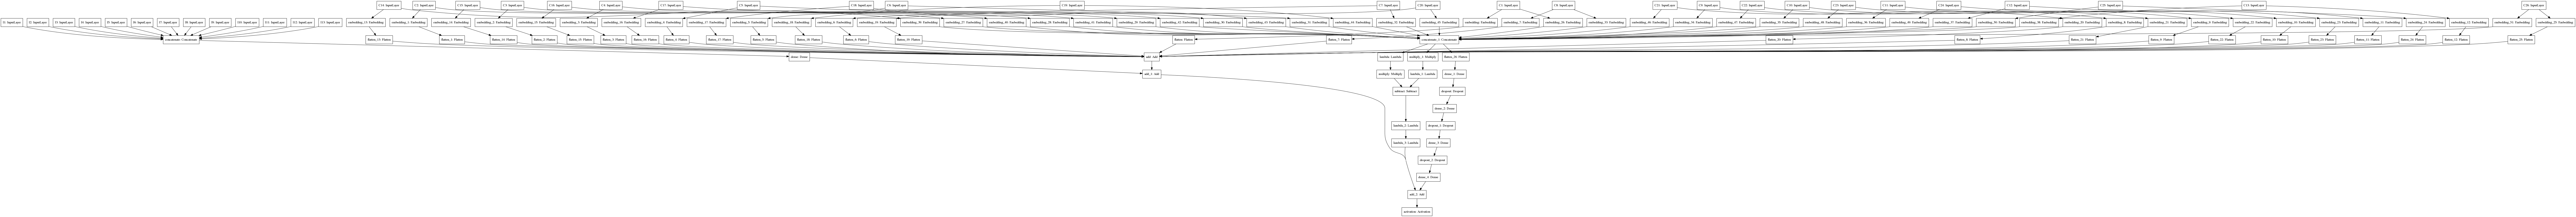

In [36]:
plot_model(model, "deepfm.png")

In [37]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
C1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C2 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C3 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C4 (InputLayer)                 [(None, 1)]          0                                            
_______________________________________________________________________________________

In [38]:
import tensorflow as tf

In [39]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["binary_crossentropy", tf.keras.metrics.AUC(name='auc')])

## 训练

In [40]:
from tensorflow.keras.callbacks import TensorBoard

In [41]:
tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=0, 
                 write_graph=True,
                 write_grads=True, 
                 write_images=True,
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

In [42]:
train_data = total_data.loc[:500000-1]
valid_data = total_data.loc[500000:]

In [43]:
train_dense_x = [train_data[f].values for f in dense_feats]
train_sparse_x = [train_data[f].values for f in sparse_feats]

In [44]:
train_label = [train_data['label'].values]

In [45]:
val_dense_x = [valid_data[f].values for f in dense_feats]
val_sparse_x = [valid_data[f].values for f in sparse_feats]

In [46]:
val_label = [valid_data['label'].values]

In [47]:
model.fit(train_dense_x+train_sparse_x, 
          train_label, epochs=5, batch_size=256,
          validation_data=(val_dense_x+val_sparse_x, val_label),
          callbacks=[tbCallBack]
         )

Epoch 1/5


/home/work/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


   1/1954 [..............................] - ETA: 0s - loss: 4503.8477 - binary_crossentropy: 0.8277 - auc: 0.6262WARNING:tensorflow:From /home/work/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1954/1954 [==============================] - 33s 17ms/step - loss: 32.7564 - binary_crossentropy: 0.5382 - auc: 0.6992 - val_loss: 0.6135 - val_binary_crossentropy: 0.5086 - val_auc: 0.7268
Epoch 2/5
1954/1954 [==============================] - 33s 17ms/step - loss: 0.5967 - binary_crossentropy: 0.5002 - auc: 0.7346 - val_loss: 0.6277 - val_binary_crossentropy: 0.5029 - val_auc: 0.7344
Epoch 3/5
1954/1954 [==============================] - 32s 16ms/step - loss: 0.6124 - binary_crossentropy: 0.4973 - auc: 0.7385 - val_loss: 0.6374 - val_binary_crossentropy: 0.5090 - val_auc: 0.7340
Epoch 4/5


In [48]:
# !tensorboard --logdir ./logs 